# Bitcoin Price Predictor

This project predicts if Bitcoin price will go **up** or **down** tomorrow.

We use:
- Bitcoin price data from CoinGecko
- Features like daily return, moving averages, and volatility
- Logistic Regression model from scikit-learn
- Evaluation with accuracy, confusion matrix, and classification report
- Plots to show predictions


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## 1. Data Collection

We get the last 180 days of Bitcoin prices from CoinGecko API.
We keep the **daily closing price** for each day.


In [2]:
def fetch_crypto_data():
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {"vs_currency": "usd", "days": "180"}
    response = requests.get(url, params=params)
    data = response.json()

    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
    df = df.groupby('date').agg({'price': 'last'}).reset_index()

    return df

df = fetch_crypto_data()
df.head()

,date,price
0,2025-08-20,112778.344836
1,2025-08-21,114252.397552
2,2025-08-22,112414.399873
3,2025-08-23,116834.249482
4,2025-08-24,115359.983467


## 2. Create Features

We make new features for the model:
- Daily return (how much the price changed each day)
- 5-day moving average
- 10-day moving average
- 5-day volatility (difference between high and low in 5 days)

We also make a **label**:
- 1 → price goes UP next day
- 0 → price goes DOWN next day


In [3]:
def create_features(df):
    df['prev_close'] = df['price'].shift(1)
    df['daily_return'] = (df['price'] - df['prev_close']) / df['prev_close']
    df['average5Days'] = df['price'].rolling(5).mean()
    df['average10Days'] = df['price'].rolling(10).mean()
    df['volatility'] = df['price'].rolling(5).max() - df['price'].rolling(5).min()

    df = df.dropna()

    df['next_price'] = df['price'].shift(-1)
    df['label'] = (df['next_price'] > df['price']).astype(int)
    df = df.dropna()

    feature_cols = ['daily_return', 'average5Days', 'average10Days', 'volatility']
    X = df[feature_cols]
    y = df['label']

    return X, y, df

X, y, df_features = create_features(df)
X.head()


,daily_return,average5Days,average10Days,volatility
9,0.011774,111833.859022,113080.867032,3214.194034
10,-0.035950,110850.010660,112651.063215,4045.290740
11,0.002781,110569.331228,112104.019188,4045.290740
12,-0.004859,109851.461414,111687.915293,4272.236483
13,0.008400,109440.781571,110920.758902,4272.236483


## 3. Split Data

We split the data into **train** and **test** sets.
We do **not shuffle** because the order of days matters.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

## 4. Scale Features

We standardize features so all numbers are on a similar scale.
This helps the Logistic Regression model work better.


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Train Logistic Regression

We use Logistic Regression to predict if the price will go UP or DOWN.
It gives a probability, and we use 0.5 as the cutoff:
- more than 0.5 → UP
- less or equal to 0.5 → DOWN


In [6]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

## 6. Evaluate Model

We check how well the model works using:
- Accuracy
- Confusion Matrix
- Precision, Recall, F1-score


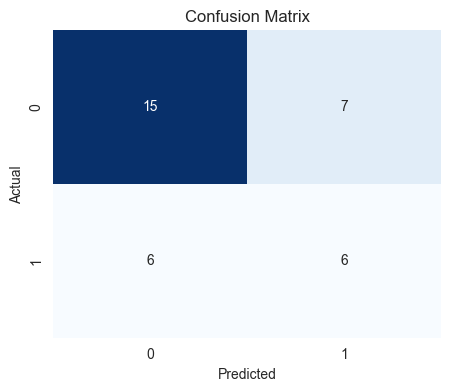

,Accuracy,UP predictions,DOWN predictions
0,0.617647,13,21


In [7]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

metrics = {
    "Accuracy": [accuracy_score(y_test, y_pred)],
    "UP predictions": [sum(y_pred==1)],
    "DOWN predictions": [sum(y_pred==0)]
}
pd.DataFrame(metrics)


## 7. Next Day Prediction

We use the last day in our data to predict if tomorrow's price will go UP or DOWN.


In [8]:
last_row = df_features.iloc[-1]

X_new = pd.DataFrame([last_row[['daily_return', 'average5Days', 'average10Days', 'volatility']]],
                     columns=['daily_return', 'average5Days', 'average10Days', 'volatility'])
X_new_scaled = scaler.transform(X_new)

pred_prob = model.predict_proba(X_new_scaled)[0][1]

print(f"Probability UP: {pred_prob*100:.2f}%")
if pred_prob > 0.5:
    print("Price likely to GO UP")
else:
    print("Price likely to GO DOWN")


Probability UP: 58.26%
Price likely to GO UP


## 8. Plot Predictions

Plot:
- Bitcoin price over time
- Predicted UP days with green
- Predicted DOWN days with red

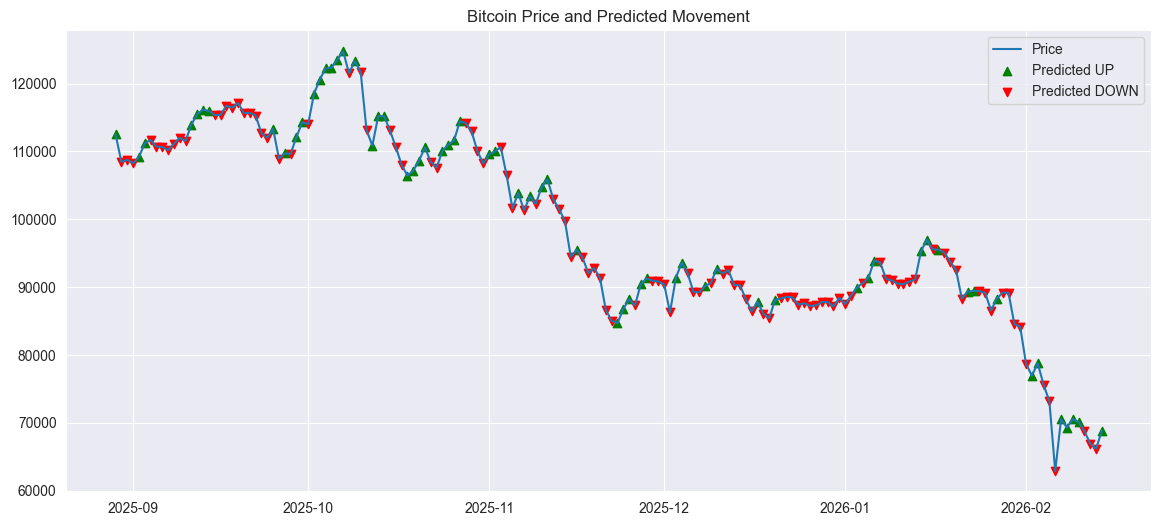

In [9]:
X_scaled = scaler.transform(df_features[['daily_return', 'average5Days', 'average10Days', 'volatility']])
df_features['pred_prob'] = model.predict_proba(X_scaled)[:, 1]
df_features['pred_label'] = (df_features['pred_prob'] > 0.5).astype(int)

plt.figure(figsize=(14,6))
plt.plot(df_features['date'], df_features['price'], label='Price')

plt.scatter(
    df_features['date'][df_features['pred_label']==1],
    df_features['price'][df_features['pred_label']==1],
    marker='^', color='green', label='Predicted UP'
)

plt.scatter(
    df_features['date'][df_features['pred_label']==0],
    df_features['price'][df_features['pred_label']==0],
    marker='v', color='red', label='Predicted DOWN'
)

plt.legend()
plt.title("Bitcoin Price and Predicted Movement")
plt.show()